<a href="https://colab.research.google.com/github/hun9008/AI_TeamProject_24FW-/blob/main/inference_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.6 MB/s eta 0:00:00


In [31]:
import torch
import time
from timm.models.vision_transformer import VisionTransformer
from timm import create_model
from matplotlib import pyplot as plt

In [4]:
class CustomViT(VisionTransformer):
    def forward_features(self, x):

        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        if hasattr(self, 'dist_token') and self.dist_token is not None:
            dist_token = self.dist_token.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_token, dist_token, x), dim=1)
        else:
            x = torch.cat((cls_token, x), dim=1)

        x = self.pos_drop(x + self.pos_embed)

        self_attn_time, ffn_time = 0, 0

        for block in self.blocks:
            start_time = time.time()
            x = block.attn(x)
            end_time = time.time()
            self_attn_time += (end_time - start_time) * 1000

            start_time = time.time()
            x = block.mlp(x)
            end_time = time.time()
            ffn_time += (end_time - start_time) * 1000

        x = self.norm(x)

        return x, self_attn_time, ffn_time

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = create_model('vit_base_patch16_224', pretrained=True)
custom_vit_model = CustomViT(patch_size=16, embed_dim=768, depth=12, num_heads=12).to(device)

In [8]:
input_tensor = torch.randn(16, 3, 224, 224).to(device)

In [9]:
with torch.no_grad():
    features, self_attn_time, ffn_time = custom_vit_model.forward_features(input_tensor)

In [10]:
output = custom_vit_model.forward_head(features)

In [21]:
print(f"Self-Attention Time: \t{self_attn_time:.2f} ms")
print(f"FFN Time: \t\t{ffn_time:.2f} ms")

Self-Attention Time: 	208.93 ms
FFN Time: 		383.45 ms


In [24]:
batch_size = [1,2,4,8,16,32,64]
SA_result = []
FFN_result = []

for bs in batch_size:
    input_tensor = torch.randn(bs, 3, 224, 224).to(device)
    with torch.no_grad():
        features, self_attn_time, ffn_time = custom_vit_model.forward_features(input_tensor)
    print(f"Batch Size: {bs}")
    print(f"Self-Attention Time: \t{self_attn_time:.2f} ms")
    print(f"FFN Time: \t\t{ffn_time:.2f} ms")
    print("")
    SA_result.append(self_attn_time)
    FFN_result.append(ffn_time)

Batch Size: 1
Self-Attention Time: 	220.83 ms
FFN Time: 		382.15 ms

Batch Size: 2
Self-Attention Time: 	406.80 ms
FFN Time: 		680.15 ms

Batch Size: 4
Self-Attention Time: 	1186.58 ms
FFN Time: 		1996.98 ms

Batch Size: 8
Self-Attention Time: 	3301.77 ms
FFN Time: 		5276.56 ms

Batch Size: 16
Self-Attention Time: 	4953.03 ms
FFN Time: 		8455.07 ms

Batch Size: 32
Self-Attention Time: 	9843.60 ms
FFN Time: 		15732.45 ms

Batch Size: 64
Self-Attention Time: 	16209.04 ms
FFN Time: 		30357.70 ms



In [28]:
gap = []

for sa, ff in zip(SA_result, FFN_result):
  abs_gap = abs(sa - ff)
  gap.append(abs_gap)
print(gap)

[161.31949424743652, 273.3585834503174, 810.3959560394287, 1974.7989177703857, 3502.039670944214, 5888.857841491699, 14148.65779876709]


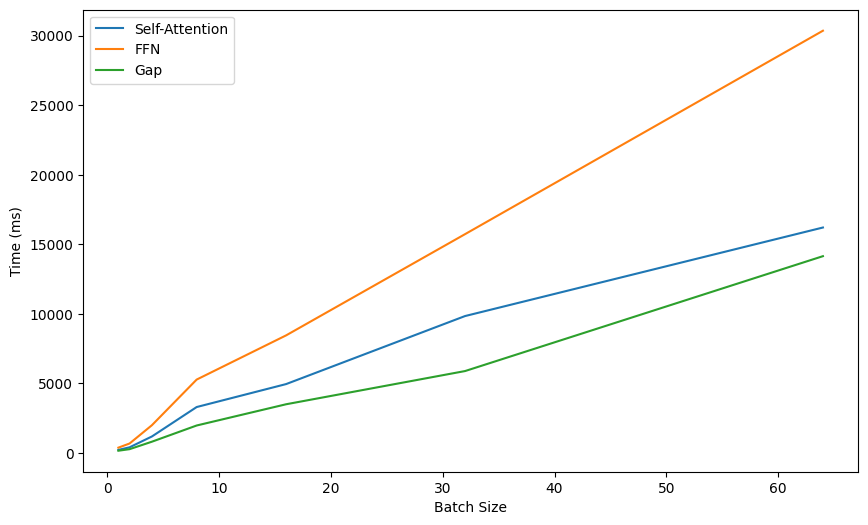

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(batch_size, SA_result, label="Self-Attention")
plt.plot(batch_size, FFN_result, label="FFN")
plt.plot(batch_size, gap, label="Gap")
plt.xlabel("Batch Size")
plt.ylabel("Time (ms)")
plt.legend()
plt.show()